In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [6]:
df_gld = pd.read_csv(r"D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\goldprice\gld_price_data.csv")
df_gld['Date'] = pd.to_datetime(df_gld['Date'])  # Đảm bảo cột 'Date' là kiểu thời gian

In [7]:
df = df_gld[['Date', 'GLD']].copy()
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

        Date        GLD
0 2008-01-02  84.860001
1 2008-01-03  85.570000
2 2008-01-04  85.129997
3 2008-01-07  84.769997
4 2008-01-08  86.779999


In [8]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df = fill_missing_values_date(df, 'Date', 'GLD')
df.set_index('Date', inplace=True)
dt_gld = df['GLD'].values
time = df.index
dt_gld = np.reshape(dt_gld, (-1,1))

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dt_gld)

In [10]:
# Định nghĩa hàm tạo các cửa sổ trượt
def create_sliding_windows(data, window_size):
    X, y = [], [] #khởi tạo tập rỗng
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [11]:
window_size = 5
X, y = create_sliding_windows(scaled_data, window_size)
X = np.reshape(X, (3783,5))


In [12]:
split_idx = 3288
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [13]:
def find_optimal_k(X_train, y_train, max_k=30):
    k_range = range(1, max_k+1)
    k_rmse_scores = []
    
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k, metric='manhattan')
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        rmse_scores = -cross_val_score(knn, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
        k_rmse_scores.append(rmse_scores.mean())
    
    # Vẽ biểu đồ RMSE theo giá trị k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, k_rmse_scores, marker='o')
    plt.xlabel('Giá trị k')
    plt.ylabel('RMSE')
    plt.title('RMSE theo các giá trị k')
    plt.show()
    
    # Tìm giá trị k có RMSE nhỏ nhất
    optimal_k = k_range[np.argmin(k_rmse_scores)]
    print(f'Giá trị k tối ưu: {optimal_k}')
    return optimal_k


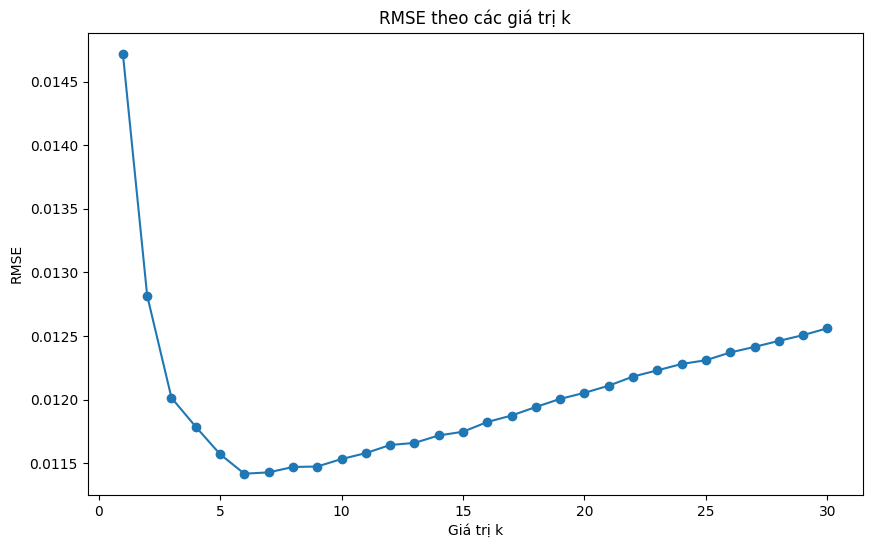

Giá trị k tối ưu: 6


In [14]:
optimal_k = find_optimal_k(X_train, y_train)

In [15]:
knn = KNeighborsRegressor(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=6)

In [16]:
y_pred = knn.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)


In [17]:
acctually_prices = df['GLD'][split_idx+window_size:]
acctually_prices = np.reshape(acctually_prices, -1)

In [18]:
# Tính Mean Squared Error
mse = mean_squared_error(acctually_prices, y_pred)
print(f"MSE: {mse}")

# Tính MAE
mae = mean_absolute_error(acctually_prices, y_pred)
print(f"MAE: {mae}")

#Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
mape = calculate_mape(acctually_prices, y_pred)
print(f"MAPE: {mape}")

MSE: 0.4567273990251931
MAE: 0.5279584806116724
MAPE: 3.5919288588460487


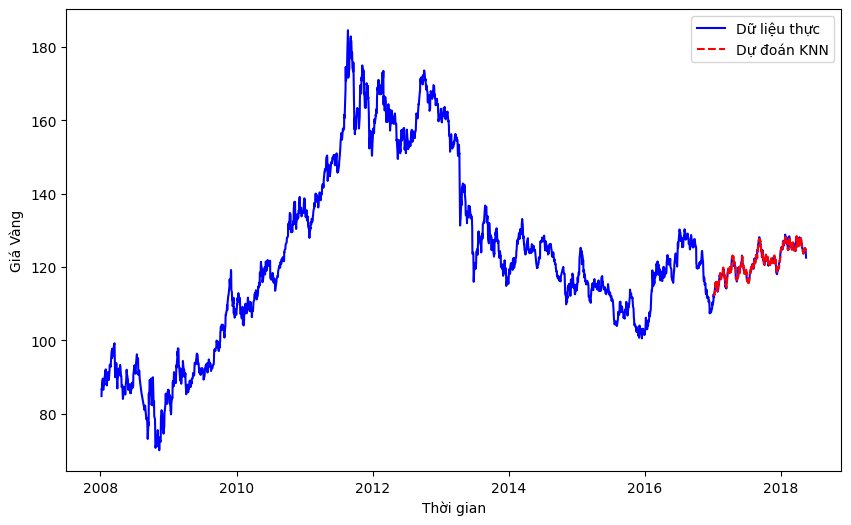

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(time[window_size:], df['GLD'][window_size:], label='Dữ liệu thực', color='blue')
plt.plot(time[split_idx+window_size:], y_pred, label='Dự đoán KNN', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Giá Vàng')
plt.legend()
plt.show()